In [147]:
import json
import geodaisy.converters as convert
import geopandas as gpd
import pandas as pd
import timeit

start = timeit.default_timer()

## Combine GEE data

In [148]:
# Load & Combine Burkina Faso events
bf1 = pd.read_csv('Data/GEE/Burkina Faso/FloodedDiff_2016-09-14_BF.csv')
bf2 = pd.read_csv('Data/GEE/Burkina Faso/FloodedDiff_2018-08-20_BF.csv')
bf3 = pd.read_csv('Data/GEE/Burkina Faso/FloodedDiff_2018-09-01_BF.csv')

bf1 = bf1.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)
bf2 = bf2.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)
bf3 = bf3.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)

bf1['flood_date'] = '2016-09-14'
bf2['flood_date'] = '2018-08-20'
bf3['flood_date'] = '2018-09-01'

bf = pd.DataFrame( pd.concat([bf1,bf2,bf3], ignore_index=True) )


In [149]:
# Load Mali events
ml1 = pd.read_csv('Data/GEE/Mali/FloodedDiff 2018-08-20 ML.csv')
ml2 = pd.read_csv('Data/GEE/Mali/FloodedDiff 2018-09-01 ML.csv')

ml1 = ml1.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)
ml2 = ml2.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)


ml1['flood_date'] = '2018-08-20'
ml2['flood_date'] = '2018-09-01'

ml = pd.DataFrame( pd.concat([ml1,ml2], ignore_index=True) )

In [150]:
# Load Niger events
ne1 = pd.read_csv('Data/GEE/Niger/FloodedDiff 2016-09-14 NE.csv')
ne2 = pd.read_csv('Data/GEE/Niger/FloodedDiff 2018-08-20 NE.csv')
ne3 = pd.read_csv('Data/GEE/Niger/FloodedDiff 2018-09-01 NE.csv')

ne1 = ne1.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)
ne2 = ne2.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)
ne3 = ne3.drop(['system:index', 'ADM0_CODE', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE', 'DISP_AREA', 'EXP2_YEAR', 'STATUS',
                'STR2_YEAR', 'Shape_Area', 'Shape_Leng'], axis=1)

ne1['flood_date'] = '2016-09-14'
ne2['flood_date'] = '2018-08-20'
ne3['flood_date'] = '2018-09-01'

ne = pd.DataFrame( pd.concat([ne1,ne2,ne3], ignore_index=True) )

In [151]:
# Combine all GEE data
gee = pd.DataFrame( pd.concat([bf,ml,ne], ignore_index=True) )
gee = gee[['ADM0_NAME', 'ADM2_NAME', 'flood_date', 'Diff', '.geo']]
gee.rename(columns = {'ADM0_NAME': 'country', 'ADM2_NAME':'admin_name'}, inplace = True)
gee['flood_date'] = pd.to_datetime(gee['flood_date'])
gee = gee.sort_values(by=['country', 'admin_name'])
gee = gee.reset_index()
gee = gee.drop(['index'], axis=1)


## Preprocess the FS0 dataset


In [152]:
# Load FS0 data for differencing
FS0 = pd.read_csv('Data/FS_before_after_data.csv')
FS0 = FS0.drop(['geometry'], axis=1)
print(list(FS0.columns))

['country', 'admin_name', 'centx', 'centy', 'state', 'datetime', 'flood_date', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'spacelag', 'timelag1', 'timelag2']


In [153]:
col = ['country', 'admin_name', 'centx', 'centy', 'flood_date', 'fews_ipc', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count',
       'acled_fatalities', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct', 'spacelag',
       'timelag1', 'timelag2']

FS = pd.DataFrame(columns=col)

x = int(len(FS0)/2)
skip = [n*2 for n in range(0, x)]
counter = 0
for i in skip:
    before = i
    after = i+2
    counter = i+1
    diff = FS0[FS0.columns[7:]][before:after].diff()
    FS = FS.append(diff)
    FS.loc[counter, ['country']] = FS0.loc[counter, ['country']]
    FS.loc[counter, ['admin_name']] = FS0.loc[counter, ['admin_name']]
    FS.loc[counter, ['flood_date']] = FS0.loc[counter, ['flood_date']]
    FS.loc[counter, ['centx']] = FS0.loc[counter, ['centx']]
    FS.loc[counter, ['centy']] = FS0.loc[counter, ['centy']]

In [154]:
FS = FS.dropna(how='all')
FS = FS.reset_index()
FS = FS.drop(['index'], axis=1)

## Combine GEE & FS0 Data

Check the df lengths because the FEWS shapefiles are likely to be different from GEE Admin 2 shapefiles.
This might require a point-in-polygon test.



In [155]:
# There is a big difference in file length - so the admin codes are likely not matching
print('FS data length: ', len(df))
print('GEE data length: ', len(gee))
test_FS = FS.drop_duplicates(subset=['country', 'admin_name'])
test_gee = gee.drop_duplicates(subset=['country', 'admin_name'])
print('Number of FS0 admin codes: ', len(test_FS))
print('Number of GEE admin codes: ', len(test_gee))

FS data length:  553
GEE data length:  349
Number of FS0 admin codes:  162
Number of GEE admin codes:  133


Create shapefiles from GEE geometry column

In [156]:

for i in test_gee.index:
    x = test_gee.loc[i, ['.geo']]
    x = json.loads(x[0])
    try:
        test_gee.loc[i, ['.geo']] = convert.geojson_to_wkt(x)
    except: # Error handling for geometry collections
        y = list(x.values())
        y = y[1]
        test_gee.loc[i, ['.geo']] = convert.geojson_to_wkt(y[1])
        continue

test_gee['.geo'] = gpd.GeoSeries.from_wkt(test_gee['.geo'])
gee_gdf = gpd.GeoDataFrame(test_gee, geometry='.geo')
gee_gdf.rename(columns = {'.geo':'geometry'}, inplace = True)
gee_gdf = gee_gdf.reset_index()
gee_gdf = gee_gdf.drop(['index'], axis=1)
gee_gdf = gee_gdf.set_crs('epsg:3857')

C:\Users\offne\.conda\envs\diss\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\offne\.conda\envs\diss\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Create points from the FS0 data.

In [157]:
# Create points
FS_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.centx, df.centy))
FS_gdf = FS_gdf.set_crs('epsg:3857')

If the FS0 admin point is within any of the GEE polygons assign that that point the GEE admin name

In [158]:
for i in gee_gdf.index:
    for j in FS_gdf.index:
        polygon = gee_gdf['geometry'][i]
        point = FS_gdf['geometry'][j]
        if polygon.contains(point) == True:
            FS['admin_name'][j] = gee_gdf['admin_name'][i]
        else:
            continue


C:\Users\offne\AppData\Local\Temp/ipykernel_15692/2645939328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FS['admin_name'][j] = gee_gdf['admin_name'][i]


Check differences between admin names after point-in-polygon test

set()
{'Commune 2', 'Commune 3'}


<AxesSubplot:>

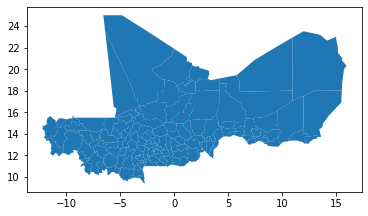

In [160]:
test_FS = FS.drop_duplicates(subset=['country', 'admin_name'])
print('Number of FS admin codes post processing: ',len(test_FS))

# Check strings and fix differences
l = set(FS['admin_name'].tolist())
x = set(gee['admin_name'].tolist())
print(set(list(l - x)))
print(set(list(x - l)))
gee_gdf.drop(gee_gdf.index[gee_gdf['admin_name'] == 'Commune 2'], inplace=True)
gee_gdf.drop(gee_gdf.index[gee_gdf['admin_name'] == 'Commune 3'], inplace=True)

gee_gdf.plot()

FS: TAKE MEAN OF VALUES WITH SAME COUNTRY, ADMIN NAME AND FLOOD DATE




In [ ]:


stop = timeit.default_timer()
print('Running Time: ', stop - start, 'seconds')